# Objectives
- Describe a driving path using a belzier
    - I need to be able to randomly generate belzier curves
    - I can use the nature of belzier curves being envelopes of non-discrete lines to my advantedge. 
    - Instead of getting the envelope, I can work backwards to just take the distance formula at each point
- Interpolate the equation of that belzier
- Export the interpolated lines into a graph
- Turn the lines into relative movement instruction
- Translate the relative movement instruction into code


## Generating Test cases
Implemented the below formula to generate random length belzier curves
<img src="belzier_formula.jpg" />

In [34]:
import scipy.special
import random
import math
scipy.special.binom(4, 2)
# Make a list with length n, with random points in the range [0,10]
import numpy as np
import matplotlib.pyplot as plt
size = random.randint(5, 10)
pointList = np.random.rand(size,2)*40
# t goes up to 1
interp = .01
def belzierPoint(pointList,t):
    x_i = 0
    y_i = 0
    n = len(pointList)
    # So then loop through the interpolate t from 0 to 1 by .1
    for i, point in enumerate(pointList):
        x_i += scipy.special.binom(n,i)*((1-t)**(n-i))*t**i*point[0]
        y_i += scipy.special.binom(n,i)*((1-t)**(n-i))*t**i*point[1]
    return x_i,y_i

def belzier(pointList, t = None):
    x,y = [],[]
    if t == None:
        for t in np.arange(0, 1+interp, interp):
            x_i,y_i = belzierPoint(pointList,t)
            x.append(x_i)
            y.append(y_i)
    return x,y
x,y = belzier(pointList)

## Generating line interpolation
The density of "t" is directly proportional to the amount of changes in the curve's area, so that can be used to implicitly apply the secant lines

In [35]:
linePoints =[]
lines = []
numLines = 10
lineInterp = 1/numLines
for i in np.arange(0, 1+lineInterp, lineInterp):
    x_i,y_i = belzierPoint(pointList,i)
    linePoints.append([x_i,y_i])
for i in range(len(linePoints)):
    if(i!=0):
        lines.append([linePoints[i-1],linePoints[i]])



## Similar Slope Merging
Some curves may still end up with two nearly continuous secant lines, so this code merges them if the angle is within 75%.
This uses recursion 

In [36]:
def reduce():
    for i in range(len(lines)):
        if(i!=0 and i<len(lines)-1):
            slope1 = (lines[i-1][0][1]-lines[i-1][1][1])/(lines[i-1][0][0]-lines[i-1][1][0])
            slope2 = (lines[i][0][1]-lines[i][1][1])/(lines[i][0][0]-lines[i][1][0])
            avg = ((slope1+slope2)/2)
            percent_diff=abs(slope1-slope2)/avg
            if(abs(percent_diff)<.75):
                lines[i-1]=[lines[i-1][0],lines[i][1]]
                lines.pop(i)
                linePoints.pop(i)
                reduce()
            length = math.sqrt((lines[i][0][1]-lines[i][1][1])**2+(lines[i][1][0]-lines[i][0][0])**2)
            if length < 1:
                print(length)
                lines[i-1]=[lines[i-1][0],lines[i][1]]
                lines.pop(i)
                linePoints.pop(i)
                reduce()
reduce()

## Making motion instructions
Compiling all the data into step by step instructions

The motion information consists of step rotation, step length, and rotation type


In [37]:
import math
distances = []
angles= []
driveInstruction= []
for i in range(len(lines)+1):
    rotationType = 'O'
    x_dist = lines[i-1][1][0]-lines[i-1][0][0]
    y_dist = lines[i-1][1][1]-lines[i-1][0][1]
    if i!=0:
        distance = math.sqrt(x_dist**2+y_dist**2)        
        prevAngle = driveInstruction[-1][1]
        angle =  (math.atan2(y_dist,x_dist)*360)/(2*math.pi)
        # Subtract out 360 degrees if the angle is greater than 360 degrees
        if abs(angle)>360:
            angle = angle - 360*((angle)/abs(angle))*int(abs(angle)/360)
        if angle<0:
            angle = 360+angle
        if abs(angle-prevAngle)>30:
            rotationType = 'R'
        
    else:
        angle = math.degrees(math.atan2(y_dist,x_dist))
        if angle<0:
            angle = 360+angle
        distance = linePoints[0]
    driveInstruction.append([distance,angle,rotationType])


## Graphing
Taking all the data currently calculated, and making it viewable

### Checking driving Instructions
- This code takes the parsed driving instructions and plots them ontop the curve. This was to double check that the conversion was done properly
- Additionally the code dumps the rotation-types points into lists so they can be individually plotted

In [38]:
import math
extraPoints = []
omniPoints = []
rotationPoints=[]
for i in range(len(driveInstruction)):
    if i!=0:
        t1 = angl
        
        angl = math.radians(driveInstruction[i][1])
        position[0]+=driveInstruction[i][0]*math.cos(angl)
        position[1]+=driveInstruction[i][0]*math.sin(angl)
        extraPoints.append([position[0],position[1]])
        if driveInstruction[i][2]=='R':
            rotationPoints.append([position[0],position[1]])
        else:
            omniPoints.append([position[0],position[1]])
    else:
        position = [linePoints[0][0],linePoints[0][1]]
        extraPoints.append(driveInstruction[0][0])
        angl = math.radians(driveInstruction[0][1])

# Theres a omni turn, and a rotation turn

### Plotting
The below code takes all the calculated data and puts it onto a colorcoded map for readability. This plot represents the analogue for what the GUI will eventually look like

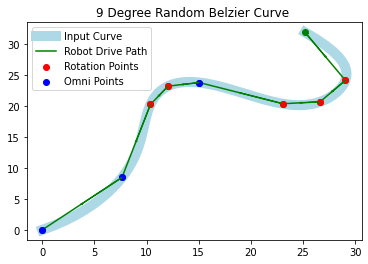

In [39]:
from matplotlib.widgets import Slider, Button, RadioButtons
plt.plot(x,y,label='Input Curve',linewidth=10,color= 'lightblue',zorder=1)

plt.title(str(size)+' Degree Random Belzier Curve ') 


x_l,y_l = zip(*extraPoints)
ax = plt.gca()
plt.scatter(x_l,y_l,color = 'g',zorder=2)
plt.plot(x_l,y_l,color = 'g',label = 'Robot Drive Path',zorder=2)


# Creating direction arrows
for i in range(len(linePoints)):
    if i<len(linePoints)-1:
        plt.arrow(x_l[i],y_l[i],(x_l[i+1]-x_l[i])/2,(y_l[i+1]-y_l[i])/2,head_width=0.2,head_length=0.2,color='g',zorder=3)
if len(rotationPoints)>0:
    x_rotation,y_rotation = zip(*rotationPoints)
    plt.scatter(x_rotation,y_rotation,color= 'r',label = 'Rotation Points',zorder = 3)

if(len(omniPoints)>0):
    x_omni,y_omni = zip(*omniPoints)
    plt.scatter(x_omni,y_omni,color= 'b',label = 'Omni Points',zorder = 3)

plt.legend()
plt.savefig('Driving Path.png',dpi = 100,facecolor='w', edgecolor='w',orientation='landscape',transparent=False, bbox_inches='tight', pad_inches=0.1)


## Translating movement into Java
- Write the driveInstruct list into a basic textfile
- Later get that into java


In [40]:
line = "A.EndDrive(10,0,0,dPower,0)"
def encDrive(d,speed,time,tab):
    tab_string = '\t'*tab
    command =  f"r.AEncDrive({d},0,{speed},0,{time});"
    return tab_string +command
def encTurn(r,speed,time,tab):
    tab_string = '\t'*tab
    command = f"r.gyroTurn({r}-r.imu.getHeading(),{speed},{time});"
    telemetry = tab_string+f"telemetry.addData(\"heading:\",r.imu.getHeading());"+tab_string+"\ntelemetry.update();"
    telemetry += f"\n {tab_string}telemetry.addData(\"turn:\",r.gyroTurn({r}-r.imu.getHeading();)"
    return tab_string + command+telemetry
tab = 2



In [41]:
def instructionWrite(tab):
    for i,instruction in enumerate(driveInstruction):
        if i==0:
            secondfile.write(f'\n\t\t// X{instruction[0][0]} Y{instruction[0][1]} R{instruction[1]}-{instruction[2]}\n')
            secondfile.write(encTurn(instruction[1],.5,4000,tab)+'\n')
        else:
            # f.write(f'\nD{instruction[0]} R{instruction[1]}-{instruction[2]}')
            secondfile.write(encDrive(instruction[0],.5,4000,tab)+"\n")
            secondfile.write(encTurn(instruction[1],.5,4000,tab)+'\n')
    secondfile.write(f'\t}} \n}}') 

In [42]:
# Copy text from basic code.txt to a new file, 
# open both files
with open('basicCode.txt','r') as firstfile, open('drivingInstruction.java','w') as secondfile:
      
    # read content from first file
    for line in firstfile:
               
             # write content to second file
             secondfile.write(line)
    instructionWrite(tab)